#### Importing packages:

In [1]:
from __future__ import print_function, division
from PyAstronomy import pyasl
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from astropy.convolution import convolve
import scipy
import math
np.warnings.filterwarnings('ignore') 
%run -i 'Cross Correlation Function.py'

Reading in the data:

In [2]:
df = pd.read_csv("xx03",delim_whitespace=True)
df = df.rename_axis("sourceId 57500450000") # Renaming axis for better visualisation
df = df.rename(columns= {"sourceId": "wavelength", "57500450000": "flux"})
print(df)

                      wavelength     flux
sourceId 57500450000                     
0                        840.000  47622.0
1                        840.001  47622.0
2                        840.002  47622.0
3                        840.003  47622.0
4                        840.004  47622.0
...                          ...      ...
49996                    889.996  41082.0
49997                    889.997  41198.0
49998                    889.998  41379.0
49999                    889.999  41595.0
50000                    890.000  41816.0

[50001 rows x 2 columns]


Resolution of dataset is 0.001nm. In comparison, RVS resolution is 0.025nm. Sanity check of data:

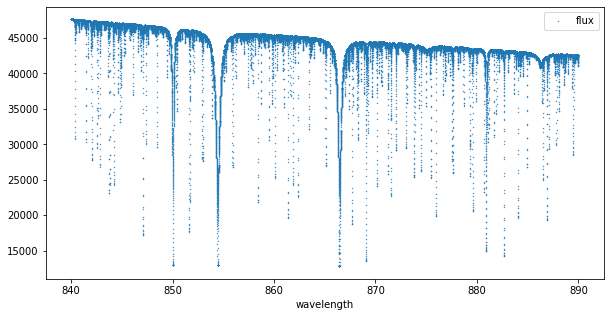

In [3]:
df.plot(style='.',x='wavelength',y='flux',ms=0.8, figsize=(10,5))
plt.show()

Single Star (can only see brighter star) - shifting wrt RV implies secondary (implied SB1 as we don't see both spectral data clearly, unlike SB2)

In principle can apply this with SB2 but becomes more complicated as two templates will be moving as opposed to one, therefore simultaneous methods

Defining parameters:

In [4]:
tw = df['wavelength']
tf = df['flux']
sig_rvs = (860.5/11500.)/2.35482 

---

IDL to Python conversion (file: normspec.pro)

In [5]:
n = df['flux'].size
x1 = 25
x2 = n-1-25
y1 = np.median(df['flux'][0:51])
y2 = np.median(df['flux'][-51:-1])
a = tf[0]

In [6]:
grad = (y2-y1)/(x2-x1)

In [7]:
linear_flux = np.zeros((n),float)
for i in range(0,n-1):
    linear_flux[i] = a + (grad*i)

In [8]:
norm_flux_array = tf/linear_flux

Normalised dataset:

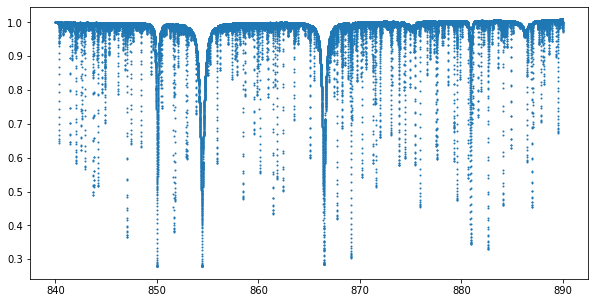

In [9]:
plt.figure(figsize=(10,5))
plt.scatter(tw, norm_flux_array, s=1)
plt.show()

Continuum normalisation. Approximating to original data.
- Trying to compare absorption lines relative to template. 
- If continuum is more sloped in parts than other, parts not always treated equally.

Converting wavelength from Pandas series to numpy array - useful later.

In [10]:
tw_series = pd.Series.to_numpy(tw, copy=False)

---

#### Radial Velocity equation for Gaia's nominal mission duration:

In [11]:
def radvel_eq(gamma,K,P,tau):
    RV = []
    for t in np.arange(0,1825):
        v = (2*math.pi)*(t-tau)/P
        RV.append(gamma + K*np.cos(v))
    return RV
radvel = radvel_eq(0,20,40,0) # in real world, i wouldnt know this first hand

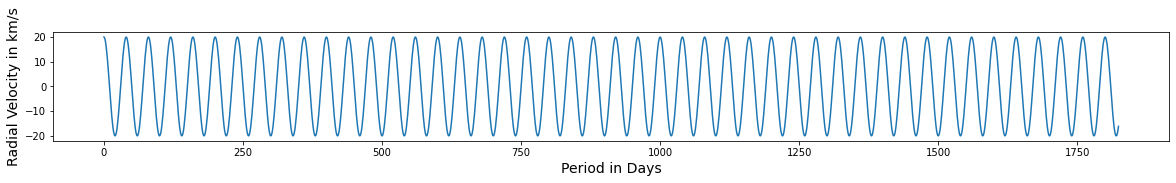

In [12]:
plt.figure(figsize=(20,2))
plt.plot(radvel)
plt.xlabel('Period in Days', fontsize=14)
plt.ylabel('Radial Velocity in km/s', fontsize=14)
plt.show()

#### Radial Velocity for 40 random observations:

In [13]:
np.random.seed(0)
rand = np.random.randint(0,1825,40)
print(rand)

[ 684  559 1653 1216  835  763 1731 1383 1033 1747  277 1778  599 1094
 1496  600 1420  314  705 1510  551   87  174 1624  849 1701  537  845
   72  777  115  976  755 1733 1455  448  850   99 1201  755]


In [14]:
def radvel_eq_Gaia(gamma,K,P,tau,rand):

    RV = []
    for t in rand:
        v = (2*math.pi)*(t-tau)/P
        RV.append(gamma + K*np.cos(v))

    return RV
radvel_gaia = radvel_eq_Gaia(0,20,40,0,rand)


##### ^^ Come back to this! Need to figure out how to save randomly generated numbers.

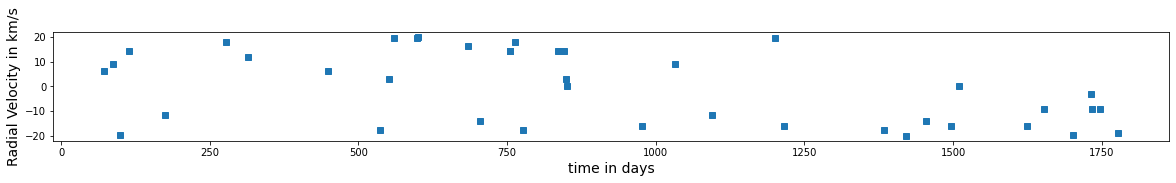

In [15]:
plt.figure(figsize=(20,2))
plt.plot(rand,radvel_gaia,'s')
plt.xlabel('time in days', fontsize=14)
plt.ylabel('Radial Velocity in km/s', fontsize=14)
plt.show()

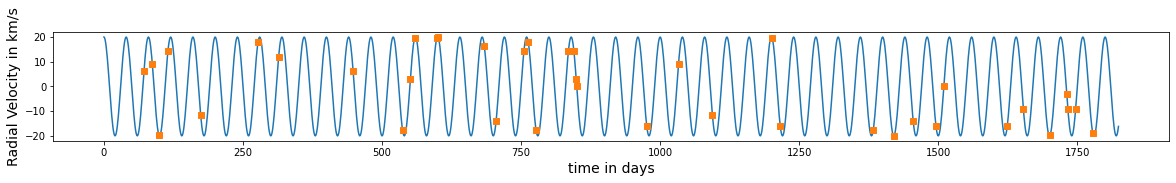

[16.18033988749904, 19.753766811902764, -9.079809994789947, -16.18033988749886, 14.142135623730614, 17.820130483767375, -3.1286893008040395, -17.820130483767315, 9.079809994790839, -9.079809994791205, 17.82013048376732, -19.02113032590284, 19.75376681190274, -11.75570504584921, -16.18033988749909, 20.0, -20.0, 11.755705045849345, -14.142135623730901, -3.6255735061127537e-13, 3.128689300804534, 9.079809994790962, -11.755705045849417, -16.180339887499148, 3.128689300804562, -19.753766811902796, -17.820130483767336, 14.14213562373096, 6.18033988749894, -17.820130483767194, 14.142135623730978, -16.180339887499045, 14.14213562373082, -9.079809994790192, -14.14213562373071, 6.180339887499001, 6.856784113952e-14, -19.753766811902757, 19.753766811902842, 14.14213562373082]


In [16]:
plt.figure(figsize=(20,2))
plt.plot(radvel)
plt.plot(rand,radvel_gaia,'s')
plt.xlabel('time in days', fontsize=14)
plt.ylabel('Radial Velocity in km/s', fontsize=14)
plt.show()
print(radvel_gaia)

Approximating that Gaia scan law.

---

#### Convolving flux with a Gaussian LSF

In [17]:
tw_conv = scipy.ndimage.gaussian_filter1d(tf,sig_rvs)

revised parameters

In [18]:
n_rev = tw_conv.size
y1_rev = np.median(tw_conv[0:51])
y2_rev = np.median(tw_conv[-51:-1])
a_rev = tw_conv[0]
grad_rev = (y2-y1)/(x2-x1)

Normalised flux from Gaussian convolution:

In [19]:
norm_flux_array2 = tw_conv/linear_flux

Appending norm_flux_array2 to dataframe:

In [20]:
df['norm_flux_array'] = norm_flux_array2

RVS wavelength range: 846-870nm:

In [21]:
norm_rvs_range = df['norm_flux_array'][(df['wavelength'] >= 846.0) & (df['wavelength'] < 870.0)]
tw_rvs_range = df['wavelength'][(df['wavelength'] >= 846.0) & (df['wavelength'] < 870.0)]

Doppler Shifting the full spectra wrt the 40 RV's calculated earlier:

In [22]:
nflux = []
wlprime = []

for i in range(40):
    nflux.append(pyasl.dopplerShift(tw_series, norm_flux_array2,radvel_gaia[i])[0])
    wlprime.append(pyasl.dopplerShift(tw_series, norm_flux_array2,radvel_gaia[i])[1])

Slicing these shifted spectra to fit the RVS wavelength range:

In [23]:
nflux_rvs = []
wlprime_rvs = []

for i in range(40):
    nflux_rvs.append(pyasl.dopplerShift(tw_series, norm_flux_array2,radvel_gaia[i])[0][6000:30000])
    wlprime_rvs.append(pyasl.dopplerShift(tw_series, norm_flux_array2,radvel_gaia[i])[1][6000:30000])

---

#### Cross Correlating

Cross correlating the template at rest as a sanity check:

In [24]:
rv_tem, cc_tem = crosscorrRV2(tw_series[6000:30000],norm_flux_array[6000:30000],tw_series,norm_flux_array,-1000.,1000.,1.,mode='doppler',skipedge=0)

In [25]:
rv = []
cc = []

for i in range(40):
    rv.append(crosscorrRV2(wlprime_rvs[i],nflux_rvs[i],tw_series,norm_flux_array,-1000.,1000.,1.,mode='doppler',skipedge=0)[0])
    cc.append(crosscorrRV2(wlprime_rvs[i],nflux_rvs[i],tw_series,norm_flux_array,-1000.,1000.,1.,mode='doppler',skipedge=0)[1])



Template cross-correlation function is maximized at RV =  0.0  km/s
Cross-correlation function is maximized at RV =  32.0  km/s
  A red-shift with respect to the template
Cross-correlation function is maximized at RV =  40.0  km/s
  A red-shift with respect to the template
Cross-correlation function is maximized at RV =  -18.0  km/s
  A blue-shift with respect to the template
Cross-correlation function is maximized at RV =  -32.0  km/s
  A blue-shift with respect to the template
Cross-correlation function is maximized at RV =  28.0  km/s
  A red-shift with respect to the template
Cross-correlation function is maximized at RV =  36.0  km/s
  A red-shift with respect to the template
Cross-correlation function is maximized at RV =  -6.0  km/s
  A blue-shift with respect to the template
Cross-correlation function is maximized at RV =  -36.0  km/s
  A blue-shift with respect to the template
Cross-correlation function is maximized at RV =  18.0  km/s
  A red-shift with respect to the templat

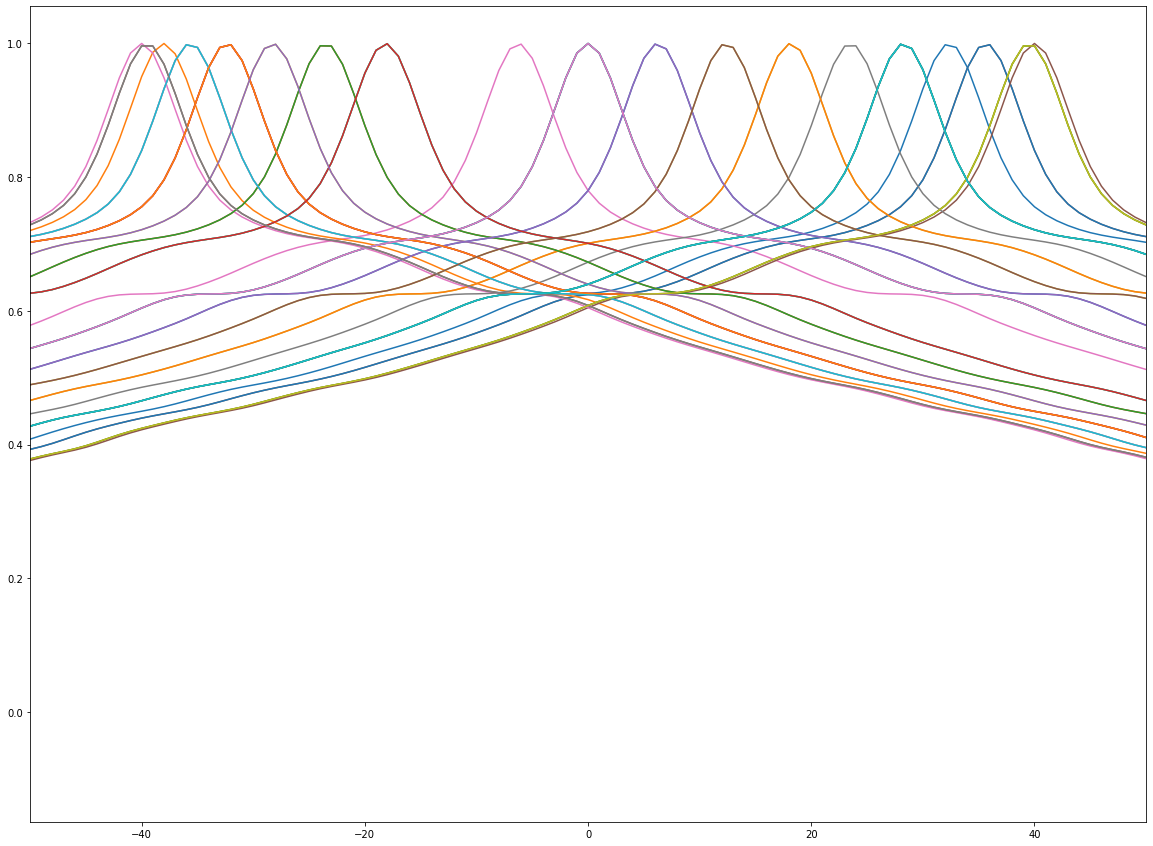

In [26]:
plt.figure(figsize=(20,15))
maxind_tem = np.argmax(cc_tem)
print("Template cross-correlation function is maximized at RV = ", rv_tem[maxind_tem], " km/s")
maxind = []
for i in range(40):
    maxind.append(np.argmax(cc[i]))


plt.plot(rv_tem,cc_tem,'k')
for i in range(40):
    plt.plot(rv[i],cc[i])
    print("Cross-correlation function is maximized at RV = ", rv[i][maxind[i]], " km/s")
    
    if rv[i][maxind[i]] > 0.0:
        print("  A red-shift with respect to the template")
    else:
        print("  A blue-shift with respect to the template")
    plt.xlim(-50,50)
plt.show()

Note: The cross correlation works. We get a systematic error in that all doppler shift values are doubled than the original answer in km/s. Do not know why this is.

In [27]:
cc_test = []
for j in range(2000):
    for i in range(40):
        cc_test.append(cc[i][j])
        split = [cc_test[x:x+40] for x in range(0,len(cc_test),40)]
        #cc_test = (eval('cc'+str(i))[j])
totals = []
for i in range(len(split)):
    sums = sum(split[i])
    sums = sums/40
    totals.append(sums)

In [28]:
len(cc_test)

80000

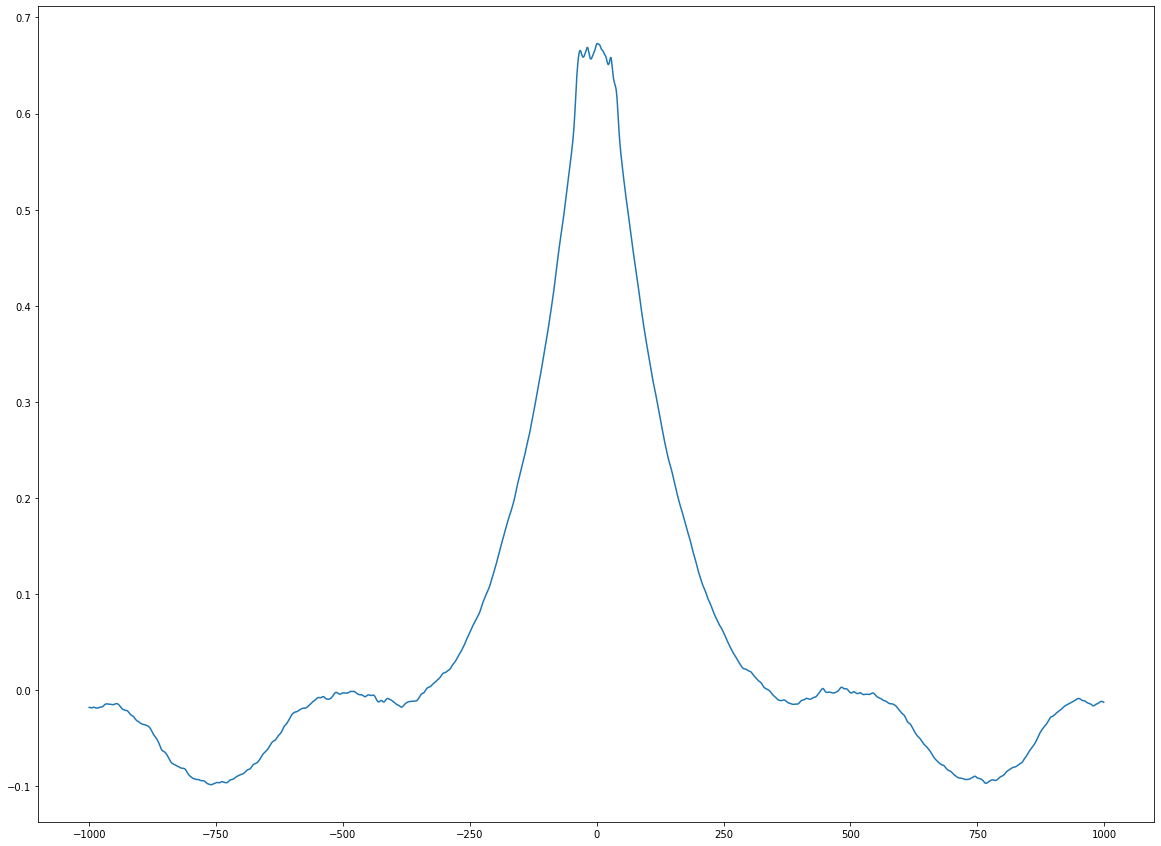

In [29]:
plt.figure(figsize=(20,15))
plt.plot(rv_tem,totals)
plt.show()

Reversing the signs of the velocity to get the opposite:

In [30]:
def reverse_signs(lst): 
    return [ -i for i in lst ]
radvel_gaia_rev = reverse_signs(radvel_gaia)
radvel_gaia_rev

[-16.18033988749904,
 -19.753766811902764,
 9.079809994789947,
 16.18033988749886,
 -14.142135623730614,
 -17.820130483767375,
 3.1286893008040395,
 17.820130483767315,
 -9.079809994790839,
 9.079809994791205,
 -17.82013048376732,
 19.02113032590284,
 -19.75376681190274,
 11.75570504584921,
 16.18033988749909,
 -20.0,
 20.0,
 -11.755705045849345,
 14.142135623730901,
 3.6255735061127537e-13,
 -3.128689300804534,
 -9.079809994790962,
 11.755705045849417,
 16.180339887499148,
 -3.128689300804562,
 19.753766811902796,
 17.820130483767336,
 -14.14213562373096,
 -6.18033988749894,
 17.820130483767194,
 -14.142135623730978,
 16.180339887499045,
 -14.14213562373082,
 9.079809994790192,
 14.14213562373071,
 -6.180339887499001,
 -6.856784113952e-14,
 19.753766811902757,
 -19.753766811902842,
 -14.14213562373082]

In [31]:
back_shift_rv = []
for i in range(40):
    back_shift_rv.append(rv[i]+(radvel_gaia_rev[i]*2))

consider this 

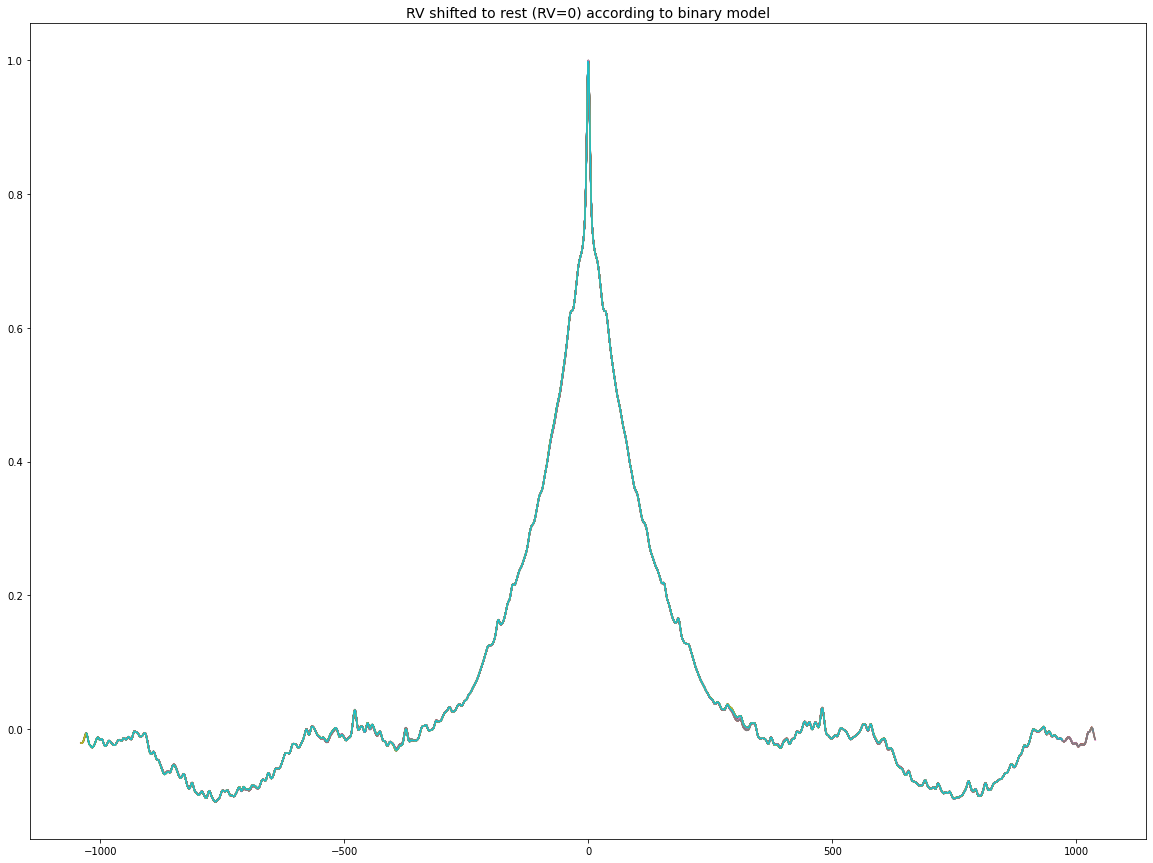

In [32]:
plt.figure(figsize=(20,15))
for i in range(40):
    #plt.plot(rv[0],cc[0])
    plt.plot(back_shift_rv[i],cc[i])
    plt.title('CCF all shifted to RV=0', fontsize=14)
    plt.title('RV shifted to rest (RV=0) according to binary model', fontsize=14)
    #plt.xlim(-50,50)

the reverse doppler shift is the "shortcut" instead of brute force.

In [33]:
tot_rv = np.arange(-1000,1001,1)
len(tot_rv)

2001

Resampling is used to put all the RV's on the same plot/axis and "space." therefore at each RV bin we can average each CCF.

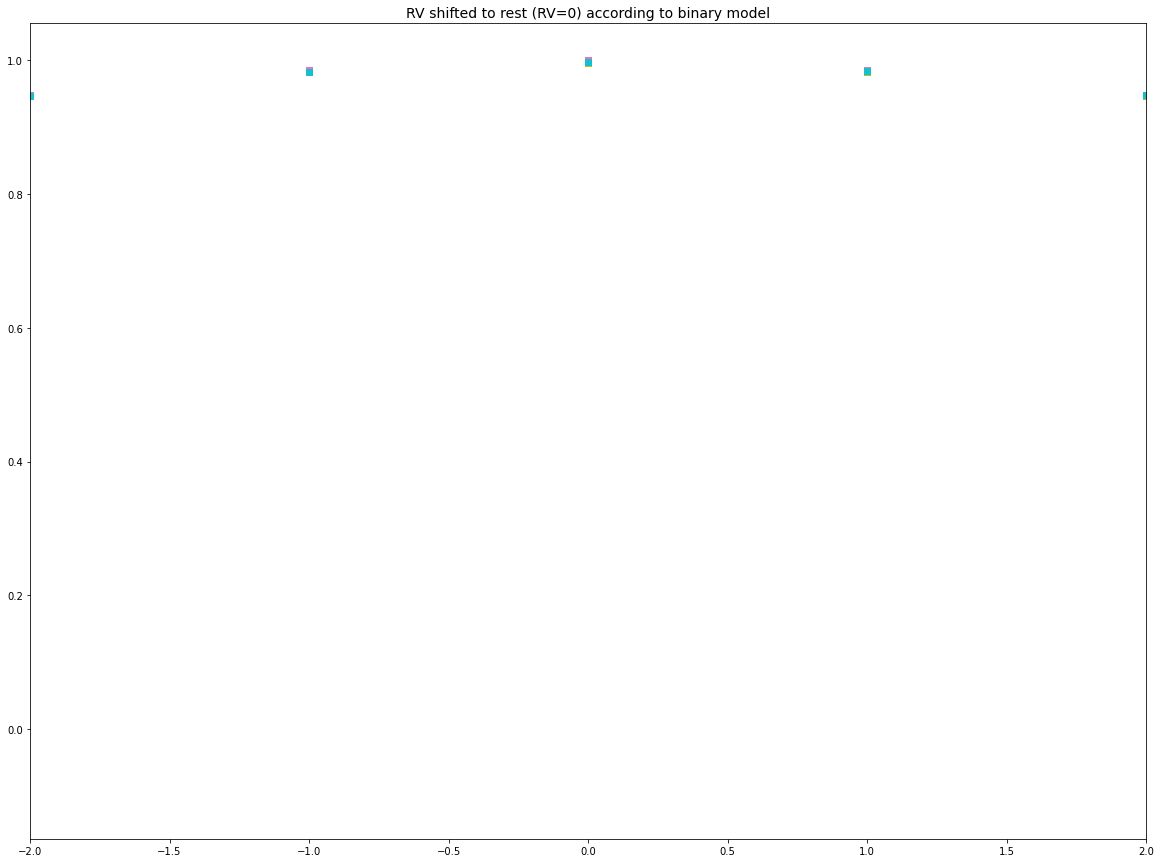

In [34]:
cc_interp = []

plt.figure(figsize=(20,15))
for i in range(40):
    cc_interp.append(np.interp(tot_rv,back_shift_rv[i],cc[i]))
    plt.plot(tot_rv,cc_interp[i],'s')
    plt.xlim(-2,2)
    plt.title('RV shifted to rest (RV=0) according to binary model', fontsize=14)

---

In [35]:
cc_interp_test = []
cc_interp_new = []
for j in range(2000):
    for i in range(40):
        cc_interp_test.append(cc_interp[i][j])
        split_interp = [cc_interp_test[x:x+40] for x in range(0,len(cc_interp_test),40)]

totals_interp = []
for i in range(len(split_interp)):
    sums_new = sum(split_interp[i])
    sums_new = sums_new/40
    totals_interp.append(sums_new)


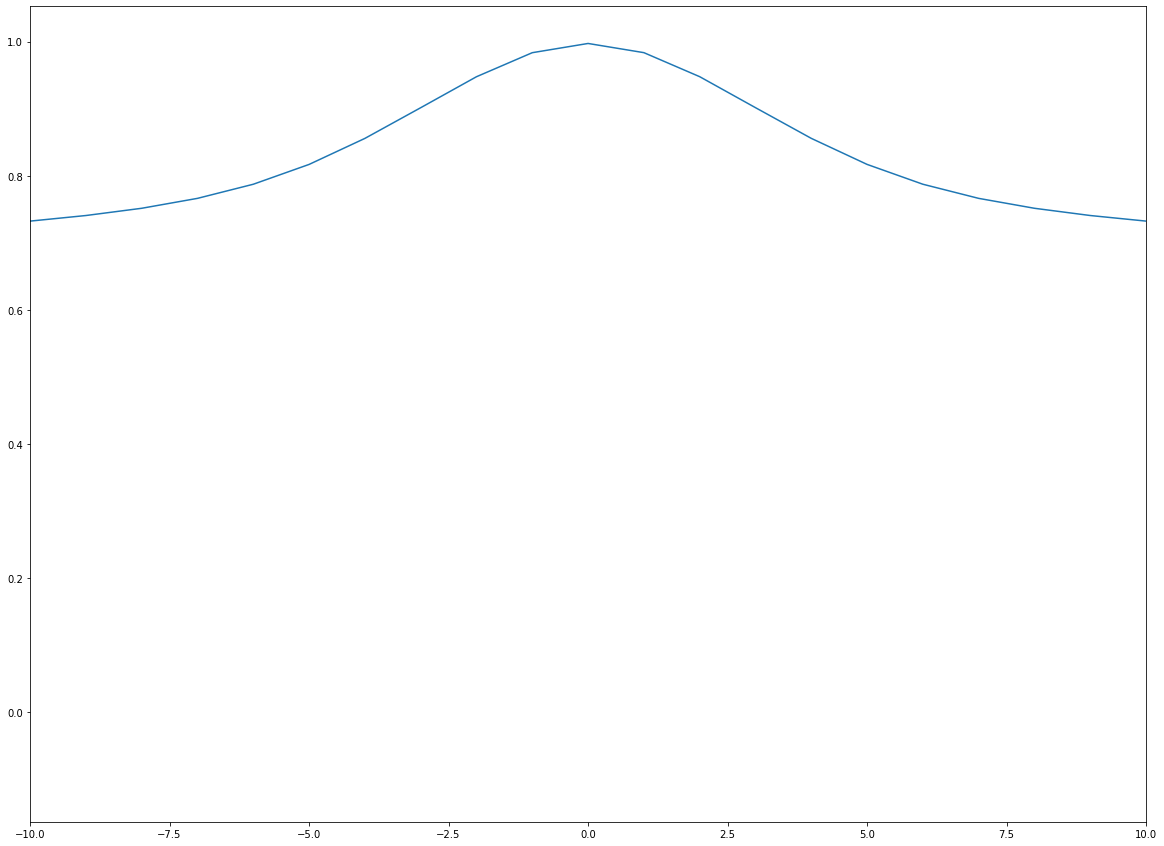

In [36]:
tot_rv_less = np.arange(-1000,1000,1)
plt.figure(figsize=(20,15))
plt.plot(tot_rv_less,totals_interp)
plt.xlim(-10,10)
plt.show()

good result.

---

([array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   997.,   998.,   999.]),
  array([-1000.,  -999.,  -998., ...,   

In [42]:

def sample(gamma,K,P,tau,rand):
    
    # Obtaining RV values
    # rand is the random sample that I generated in the beginning to get the original 40 RV values. If this needs to
    # be changed, can be done.
    RV_sample = []
    for t in rand:
        v = (2*math.pi)*(t-tau)/P
        RV_sample.append(gamma + K*np.cos(v))
        
    # Reversing RV values for original 40 values that were just obtained
    radvel_gaia_rev_sample = reverse_signs(RV_sample)
    
    # Shifting back the original CCF's from earlier by the RV values obtained in the previous step
    back_shift_rv2 = []
    for i in range(40):
        back_shift_rv2.append(rv[i]+(radvel_gaia_rev_sample[i]*2))

    # plotting the rest (RV=0) graphs 
    for i in range(40):
        plt.plot(back_shift_rv2[i],cc[i])
        plt.title('CCF all shifted to RV=0', fontsize=14)
        plt.title('RV shifted to rest (RV=0) according to binary model', fontsize=14)

    # resmapling onto a new template from -1000 to 1000 in steps of 1km/s
    tot_rv_sample = np.arange(-1000,1001,1)
    cc_interp_sample = []
    for i in range(40):
        cc_interp_sample.append(np.interp(tot_rv_sample,back_shift_rv2[i],cc[i]))
        
    # splitting the sample into batches of 40 to be able to perform the next step.
    cc_interp_test_sample = []
    cc_interp_new_sample = []
    for j in range(2000):
        for i in range(40):
            cc_interp_test.append(cc_interp[i][j])
            split_interp = [cc_interp_test_sample[x:x+40] for x in range(0,len(cc_interp_test_sample),40)]

    # taking each index of the 40 values and performing averaging calculations
    totals_interp_sample = []
    for i in range(len(split_interp)):
        sums = sum(split_interp[i])
        sums  = sums_new/40
        totals_interp_sample.append(sums)
    
    # Notes: rv,cc are the original 40 radial velocities and CCFs. 
    
    return back_shift_rv2[i],cc